In [1]:
#!/usr/bin/Rscript

suppressPackageStartupMessages({
    library(GenomicRanges)
    library(GenomicFiles)
    library(rtracklayer)
    library(viridis)
    library(foreach)
    library(doParallel)
    library(data.table)
    library(ggplot2)
});

registerDoParallel(cores=7);
source("./CoPRO_Functions.r");
genomef = "~/bin/genomes/hg19/hg19.2bit";
options(repr.plot.width=4, repr.plot.height=3, jupyter.plot_mimetypes = "image/svg+xml");

In [2]:
load('../data/CoPRO_hg19_dm6/CoPRO_AllMerge_Pooled.Rdata');
Pooled = Pooled[Pooled$C > 0]
Pooled$U = NULL;
Pooled$R = NULL;
Pooled

GRanges object with 17555997 ranges and 3 metadata columns:
             seqnames      ranges strand |         ID5         ID3         C
                <Rle>   <IRanges>  <Rle> |   <numeric>   <numeric> <integer>
         [1]     chrM 16432-16571      - | -3095693983 -3095693844         1
         [2]     chrM 16491-16571      - | -3095693983 -3095693903         2
         [3]     chrM 16484-16571      - | -3095693983 -3095693896         1
         [4]     chrM 16385-16567      - | -3095693979 -3095693797         1
         [5]     chrM 16483-16567      - | -3095693979 -3095693895         2
         ...      ...         ...    ... .         ...         ...       ...
  [17555993]     chrM 16424-16494      + |  3095693836  3095693906         1
  [17555994]     chrM 16463-16508      + |  3095693875  3095693920         1
  [17555995]     chrM 16491-16537      + |  3095693903  3095693949         1
  [17555996]     chrM 16497-16548      + |  3095693909  3095693960         1
  [17555997]    

In [3]:
#Pooled = Pooled[ width(Pooled) <= 500 ];
Pooled = Pooled[ order(Pooled$ID5) ];
Pooled = Pooled[ seqnames(Pooled) != "chrM" ];

ReadTable = as.data.table(mcols(Pooled));
setkey(ReadTable, ID5);
# compute width & number of 3' ends
ReadTable[, width := abs(ID5-ID3)+1];

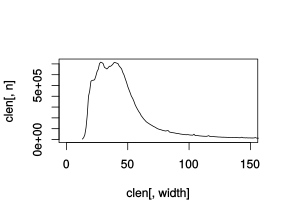

In [4]:
clen = ReadTable[ C>0, .(n=sum(C)), by=width ][order(width)];
plot(
    x=clen[,width],
    y=clen[,n],
    xlim=c(0,150), type='l'
)

In [5]:
totrd = sum(Pooled$C);
msgout(pn(totrd), "total reads");

30,564,273 total reads


In [6]:
collapse_reads = function(reads) {
    uniq = unique(reads);
    # sum over duplicates to get a count for each unique 5'/3' end
    uniq$count = countOverlaps( uniq, reads, type="equal" );
    return( uniq );
}

In [10]:
x = (1:10) * 3E6;
nTSB = c();
nTSS = c();

for( rdlim in x ) {
    randr = sample(1:length(Pooled), rdlim, replace=T, prob=Pooled$C/totrd );
    sread = collapse_reads( Pooled[randr] );
    sread$C = sread$count;
    sread$count = NULL;
    sread = sread[order(sread$ID5)]
    
    msgout(pn(sum(sread$C)), "sampled reads");

    ReadTable = as.data.table(mcols(sread));
    setkey(ReadTable, ID5);
    # compute width & number of 3' ends
    ReadTable[, width := abs(ID5-ID3)+1];
    
    # require 3 distinct 3' ends AND 4+ Capped reads in the pause
    ReadTable = ReadTable[ , .(totC = sum(C), totN = .N, psN=sum(width <= 55) ), by=ID5 ];
    erly      = ReadTable[ psN >= 3 & totC >= 10 ];
    TSB       = sread[ sread$ID5 %in% erly[,ID5] ];
    sTSB = TSB[ !duplicated(TSB$ID5) ];
    sTSB = resize( sTSB, width=1 );
    sTSB$ID3 = NULL;
    msgout(pn(length(sTSB)), "TSB calls");
    nTSB = append(nTSB, length(sTSB));

    TSS = compute_TSS( sTSB, 60 );
    msgout(pn(length(TSS)), "TSS calls");
    nTSS = append(nTSS, length(TSS));
}

3,000,000 sampled reads
32,064 TSB calls
14,817 TSS calls
6,000,000 sampled reads
72,795 TSB calls
23,872 TSS calls
9,000,000 sampled reads
112,955 TSB calls
30,455 TSS calls
12,000,000 sampled reads
152,237 TSB calls
35,925 TSS calls
15,000,000 sampled reads
189,959 TSB calls
40,952 TSS calls
18,000,000 sampled reads
225,938 TSB calls
45,239 TSS calls
21,000,000 sampled reads
261,071 TSB calls
49,522 TSS calls
24,000,000 sampled reads
294,927 TSB calls
53,195 TSS calls
27,000,000 sampled reads
327,328 TSB calls
56,892 TSS calls
30,000,000 sampled reads
358,792 TSB calls
60,465 TSS calls


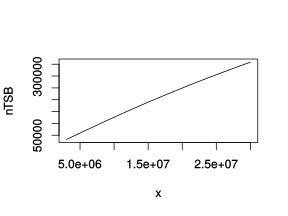

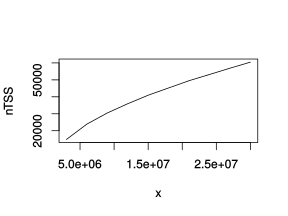

In [11]:
matplot(x, nTSB, type="l");
matplot(x, nTSS, type="l");